In [1]:
import numpy as np
from PIL import Image
import taichi as ti
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from utils import run_optimization, resample_polyline, get_area

ti.init(arch=ti.gpu)

[Taichi] version 1.7.3, llvm 15.0.1, commit 5ec301be, win, python 3.12.3
[Taichi] Starting on arch=cuda


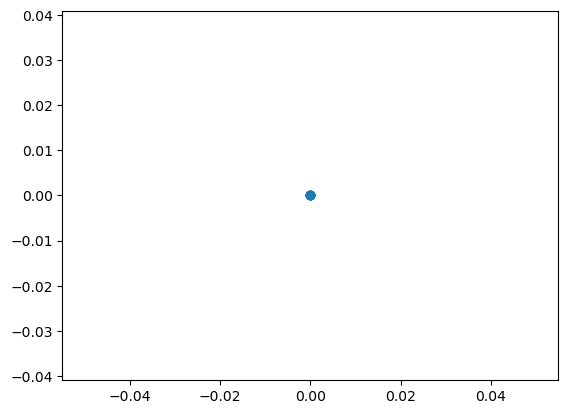

In [ ]:
def init_trajectory(sofa_w, sofa_h, control_point_num, angle=np.pi * 2 / 10):  # 生成初始轨迹
    xs, ys, rotations = resample_polyline([
        [0, 0, 0],
        [0, 0, angle]
    ], control_point_num).T
    return xs, ys, rotations

r1, r2, r3 = 0, 7, 15  # 走廊形状参数 0, 7, 11 0, 7, 15
teeth_count = 4  # 齿轮齿数 10
sofa_w = r3 * 2  # 求解域的尺寸
sofa_h = sofa_w  # 求解域的尺寸

xs, ys, rotations = init_trajectory(  # 初始轨迹
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    control_point_num=7,  # 轨迹的控制点数量 15 7
    # angle=np.pi * 2 / teeth_count
    angle=np.pi * 2 / (teeth_count + 1)
    # angle=np.pi * 2
)

plt.scatter(xs, ys)
plt.axis('equal')
plt.show()

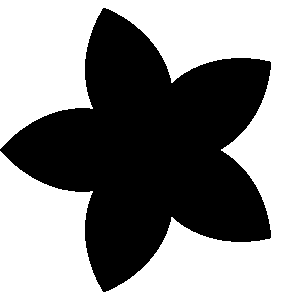

In [44]:
# 定义哪里是墙

from utils import test_forbidden_function

@ti.func
def is_forbidden(x, y):  # 指定哪里是墙（齿形1）
    r = (x ** 2 + y ** 2) ** 0.5
    a = ti.atan2(y, x)
    a = a / (2 * np.pi) * (teeth_count + 1)  # 外圈必须比内圈多一齿
    r_wall = r2 + (r3 - r2) * 2 * ti.abs(a - ti.round(a))  # 三角波
    return r < r1 or r > r_wall

# shape_parameter = 0.5  # 影响齿形的参数
# @ti.func
# def is_forbidden(x, y):  # 指定哪里是墙（齿形2，可用于生成正方形）
#     r = (x ** 2 + y ** 2) ** 0.5
#     a = ti.atan2(y, x)
#     a = a / (2 * np.pi) * (teeth_count + 1)  # 外圈必须比内圈多一齿
#     r_wall = r2 / ti.cos(ti.abs(a - ti.round(a)) * shape_parameter * np.pi)
#     return r < r1 or r > r_wall

image = test_forbidden_function(is_forbidden, -sofa_w / 2, sofa_w / 2, -sofa_h / 2, sofa_h / 2, 300)
Image.fromarray(np.array(image.T[::-1] * 255, dtype=np.uint8))

In [ ]:
# xs, ys, rotations = np.load('../trajectory/齿轮/sofa_239.npy')

In [29]:
# from utils import monotonicly_interpolate

# keys = xs - ys  # 要求这个函数单调递增来重新采样
# xs, ys, rotations = monotonicly_interpolate(
#     keys,
#     np.array([xs, ys, rotations]).T,
#     len(xs) * 2 + 1,
#     key_min=keys[0],
#     key_max=keys[-1]
# ).T

Initial survivors: 200.03700256347656
iter 500 / 5000, maximal_area=200.03700256347656
iter 1000 / 5000, maximal_area=200.03700256347656
iter 1500 / 5000, maximal_area=200.04043579101562
iter 2000 / 5000, maximal_area=200.06446838378906
iter 2500 / 5000, maximal_area=200.07476806640625
iter 3000 / 5000, maximal_area=200.07476806640625
iter 3500 / 5000, maximal_area=200.0885009765625
iter 4000 / 5000, maximal_area=200.11253356933594
iter 4500 / 5000, maximal_area=200.11940002441406
iter 5000 / 5000, maximal_area=200.12283325195312
Done. Time: 11.90s
Estimated maximal sofa area (by sampling): 200.12283
Saved sofa_survivors.png


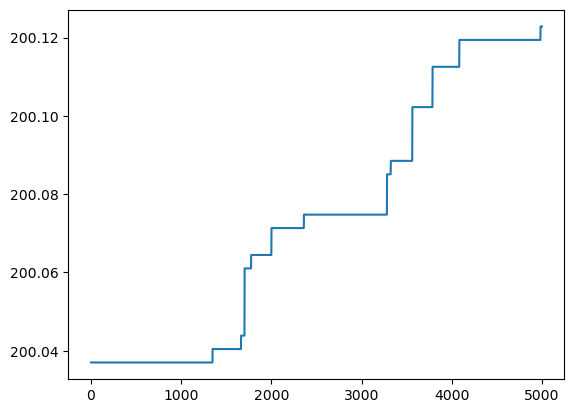

In [48]:
best_score, xs, ys, rotations, sofa, maximal_area_record = run_optimization(
    is_forbidden,
    # 一开始解除注释这三个
    # xs,
    # ys,
    # rotations,
    
    # 精炼结果时解除注释这三个
    zoom(xs, zoom=2, order=1),  # 上采样以获得更精确的轨道
    zoom(ys, zoom=2, order=1),  # 上采样以获得更精确的轨道
    zoom(rotations, zoom=2, order=1),  # 上采样以获得更精确的轨道

    sofa_w=sofa_w,
    sofa_h=sofa_h,
    mutation_sigma_pos=0.2,  # 变异率 0.02
    mutation_sigma_rotation=0.04,  # 变异率 0.004
    iterations=5000,  # 200000
    trajectory_upsampling=101,  # 41 101
    resolution=512,  # 1024 2000
    print_every=500,  # 1000
    save_image_every=10,  # 83
    save_image_path='../images/五角星/sofa_',
    save_image_start_id=1000,  # 文件起始编号，精炼结果时需要设置
    save_trajectory_path='../trajectory/五角星/sofa_'
)
print(f"Estimated maximal sofa area (by sampling): {best_score:.5f}")
# save mask image as PNG if pillow is available

img = (sofa * 255).astype(np.uint8)
im = Image.fromarray(img.T[::-1])
im.save('sofa_survivors.png')
print('Saved sofa_survivors.png')
plt.plot(maximal_area_record)

In [29]:
maximal_area_record[-1] / maximal_area_record[0]

1.1213395638629284

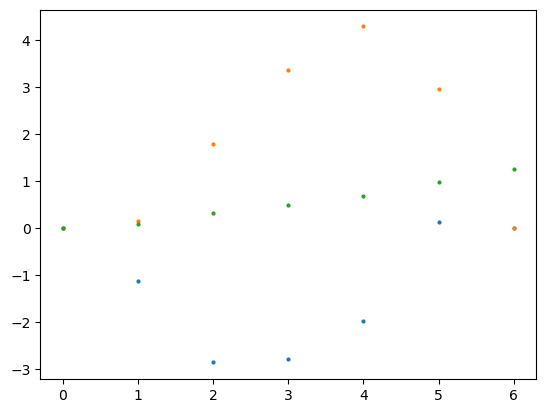

In [46]:
plt.plot(xs, 'o', markersize=2)
plt.plot(ys, 'o', markersize=2)
plt.plot(rotations, 'o', markersize=2)